<a href="https://colab.research.google.com/github/jackylmw/Week4-Neural_Network/blob/Assignment4_JackyLam/JackyLam_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Preprocessing

## Feature Engineering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import librosa.display
import soundfile


import warnings; warnings.filterwarnings('ignore')

## Merge EmoDB and RAVDESS

In [ ]:

actor_id = {
    "03": "25",
    "08": "26",
    "10": "27",
    "09": "28",
    "11": "29",
    "13": "30",
    "12": "31",
    "14": "32",
    "15": "33",
    "16": "34",
}

emotion = {"W": "05",
           "E": "07",
           "A": "06",
           "F": "03",
           "T": "04",
           "N": "01",
           "L": "09"}

versions = {
    "a": "01",
    "b": "02",
    "c": "03",
    "d": "04",
    "e": "05",
    "f": "06"}

In [ ]:
import os

os.chdir(os.path.dirname("/content/drive/MyDrive/IAT481/wav"))

if not os.path.exists("./EmoDB"):
    os.mkdir("./EmoDB")

files = os.listdir("./wav")

for f in files:
    new_f = (
        "03-01-"
        + emotion[f[5]]
        + "-01-"
        + f[2:5]
        + "-"
        + versions[f[6]]
        + "-"
        + actor_id[f[0:2]]
        + ".wav"
    )

    if not os.path.exists("./EmoDB/Actor_" + actor_id[f[0:2]]):
        os.mkdir("./EmoDB/Actor_" + actor_id[f[0:2]])

    ravdess_emotion=new_f.split("-")[2]
    if (ravdess_emotion == '02' or ravdess_emotion == '08' or ravdess_emotion == '09'):
        os.remove("./wav/" + f)
        continue


    os.rename("./wav/" + f, "./EmoDB/Actor_" + actor_id[f[0:2]] + "/" + new_f)



Now, the bored, calm and surprised audio files are removed from the dataset.

# Feature Extration


The feature extration methods provided at tutorial serve as a good example. I will use them as a starting point for my own implementation.

We will get a chromagram, a mel spectorgram, and MFC coefficients for each of our audio files. Then we will save them into one feature array and one local file.

**Chromagram**: Will produce 12 features; One for each of 12 pitch classes

**Mel Spectrogram**: Will produce 128 features; The number of mel frequency n_mels=128

**MFCC**: Will produce 40 MFCCs; The number of coefficients to return at n_mfcc=40.

In [ ]:

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate, n_mels = 128):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=n_mels, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate, n_mfcc = 40):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=n_mfcc).T, axis=0)
    return mfc_coefficients

In [ ]:

def get_features(file, n_mels=128, n_mfcc=40):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate,n_mels)
        mfc_coefficients = feature_mfcc(waveform, sample_rate,n_mfcc)

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

## Load the dataset

In [ ]:
#Emotions in the RAVDESS dataset
emotions ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [ ]:
def get_file_list(file_path, fileList):
    """
    Get the list of files in the given directory.
    """
    newFilePath = file_path
    if os.path.isfile(file_path):
        if ".wav" in file_path:
            if "Audio_Speech_Actors" in file_path:
                ravdess_emotion=file_path.split("-")[3]
                if (ravdess_emotion == '02' or ravdess_emotion == '08' or ravdess_emotion == '09'):
                    print(f"skip {file_path}")
            # os.remove(file_path)
                else:
                    fileList.append(file_path)
            else:
                fileList.append(file_path)
    elif os.path.isdir(file_path):
        for s in os.listdir(file_path):
            newFilePath = os.path.join(file_path, s)
            get_file_list(newFilePath, fileList)
    return fileList

# print(get_file_list("./", []))

In [ ]:
def load_data():
    X,y=[],[]
    count = 0
    # os.chdir(os.path.relpath(file_path))
    # print(os.getcwd())
    # RAVDESS_files  = os.listdir("./Audio_Speech_Actors_01-24/")
    # EmoDB_files  = os.listdir("./EmoDB/Actor_*/*.wav")
    files = []
    get_file_list("./", files)
    print(f"There are {len(files)} files")
    # files.append(RAVDESS_files)
    # files.append(EmoDB_files)
    # for file in glob.glob("/content/drive/MyDrive/Audio_Speech_Actors_01-24/Actor_*/*.wav"):

    for file in files:
        print(f"Cur file = {file}")
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        features = get_features(file)
        X.append(features)
        y.append(emotion)
        count += 1
        # '\r' + end='' results in printing over same line
        print('\r' + f' Processed {count}/{len(files)} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms

    return np.array(X), np.array(y)

In [ ]:
features, emotions = load_data()

skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-02-01-01-01-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-02-01-01-02-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-02-01-02-01-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-02-01-02-02-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-02-02-02-02-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-02-02-01-01-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-02-02-01-02-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-02-02-02-01-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-08-01-01-01-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-08-01-01-02-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-08-01-02-01-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-08-02-02-01-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-08-02-01-02-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-08-02-01-01-08.wav
skip ./Audio_Speech_Actors_01-24/Actor_08/03-01-08-01-02-02-08

In [ ]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display


#making dataframe for emotions as well
emotions_df = pd.DataFrame(emotions) # make it pretty for display

features_df


Audio samples represented: 1508
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.552044,0.535171,0.556097,0.588405,0.589834,0.672487,0.636099,0.544715,0.449636,0.444902,...,-0.108259,3.153732,0.065643,1.516738,1.901363,5.629809,2.819403,0.323485,1.558706,2.175961
1,0.427667,0.413010,0.451438,0.506263,0.505631,0.543930,0.626031,0.726948,0.814510,0.675843,...,12.107535,12.279272,8.584341,7.363523,5.483637,5.392119,2.537245,1.745779,-1.973541,-0.268733
2,0.549794,0.516983,0.542985,0.579875,0.593149,0.552427,0.497348,0.536326,0.565919,0.608450,...,4.104549,2.483110,1.508002,-0.101411,1.318642,-0.516518,-0.449560,0.822218,-0.491430,-0.244153
3,0.445305,0.442020,0.440741,0.498865,0.507914,0.524596,0.603100,0.507845,0.500096,0.465092,...,0.884656,1.411190,1.415958,2.955329,0.951602,2.664654,1.054188,-1.648974,1.843703,1.675059
4,0.433717,0.445429,0.502707,0.585007,0.666199,0.718931,0.705370,0.663788,0.605310,0.526737,...,1.648122,4.377116,4.941676,6.807355,5.150170,6.587804,6.824254,6.420888,5.731934,5.495753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.698092,0.714610,0.696258,0.671059,0.725568,0.753947,0.759899,0.698652,0.657629,0.666128,...,-2.399961,-1.986938,-3.592014,-1.216559,-1.496076,-0.678124,-0.682859,-1.192354,-3.034461,-3.076465
1504,0.638355,0.647221,0.643434,0.639843,0.698736,0.733060,0.726851,0.688372,0.685586,0.675857,...,-3.043192,-2.192662,-3.915255,-1.324991,-1.069489,-0.399481,-0.200425,-0.003788,0.414964,-0.498610
1505,0.615497,0.605093,0.598808,0.609242,0.644683,0.714146,0.720604,0.652430,0.619152,0.641362,...,1.027437,4.242674,3.101113,3.189771,2.951053,2.859530,2.474011,2.682413,1.167767,-1.088687
1506,0.663238,0.658323,0.643333,0.640444,0.698052,0.775355,0.798844,0.723498,0.686428,0.665593,...,-2.923509,-3.335487,-4.282575,-2.269880,-1.606522,-1.687629,-1.382490,-0.921929,-1.975646,-2.783067


We save the data into csv files instead of excel.

In [ ]:
features_df.to_csv('featuresRavdess_EmoDB.csv')
emotions_df.to_csv('emotionsRavdess_EmoDB.csv')

# Dataset Extration

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import librosa.display
import soundfile

import warnings; warnings.filterwarnings('ignore')

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir(os.path.dirname("/content/drive/MyDrive/IAT481/wav"))

In [ ]:
features=pd.read_csv('featuresRavdess_EmoDB.csv',index_col=0)
emotions=pd.read_csv('emotionsRavdess_EmoDB.csv',index_col=0)

In [ ]:
print(features.shape)
print(emotions.shape)

(1508, 180)
(1508, 1)


See the class balance

['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad'] 
 [319 238 260 262 175 254]


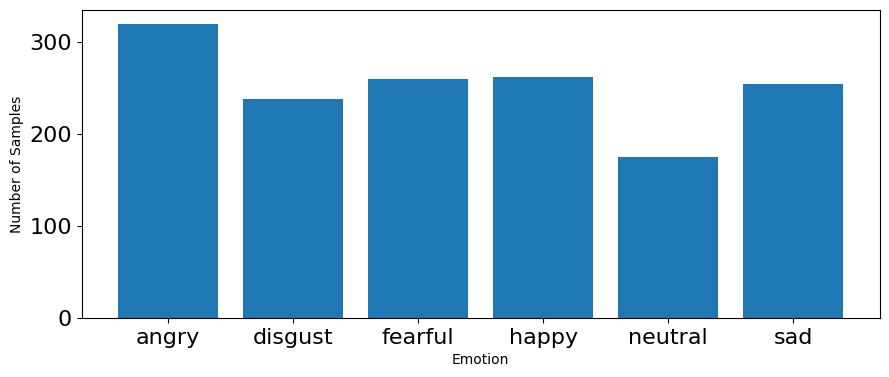

In [ ]:

# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions, return_counts=True)
print(f"{emotion_list} \n {count}")
plt.bar(x=range(len(emotion_list)), height=count)
plt.xticks(ticks=range(len(emotion_list)), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

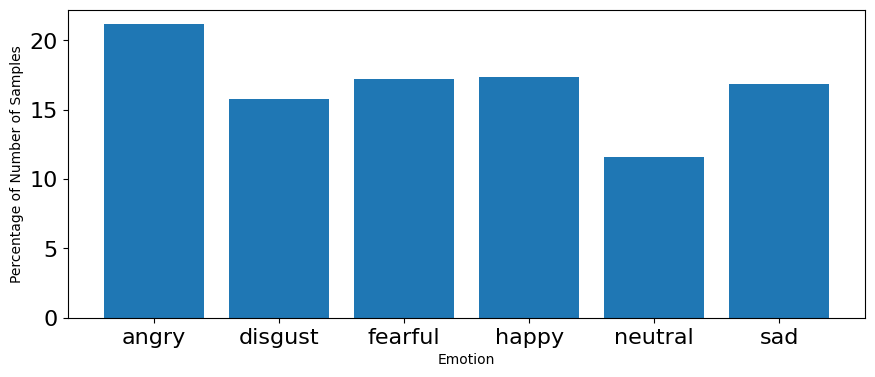

In [ ]:

# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions, return_counts=True)
plt.bar(x=range(len(emotion_list)), height=count * 100.0 / emotions.shape[0])
plt.xticks(ticks=range(len(emotion_list)), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Percentage of Number of Samples')
plt.show()

As we see from the results, our sample is slightly imbalanced, with angry (17%) as the dominant class, and neutral (9%). But the other 7 classes are balanced and around 10%. I don't think this level of imbalance would be a problem for our model. So let's continue.

## Feature Scaling

In [ ]:
features.describe()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
count,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,...,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000
mean,0.617049,0.614849,0.621540,0.633462,0.648530,0.656108,0.658340,0.653426,0.656288,0.646575,...,0.356814,1.032720,0.210298,1.136802,0.663080,0.835098,0.651004,0.971795,0.477350,1.023648
std,0.088879,0.093139,0.094923,0.095439,0.099054,0.096296,0.092240,0.088481,0.088963,0.088555,...,2.892718,2.856536,2.595157,2.561072,2.277564,2.275660,2.153255,2.132158,2.109257,2.178214
min,0.359126,0.340238,0.299362,0.303413,0.325203,0.355683,0.303241,0.328593,0.387703,0.333790,...,-5.994778,-5.506482,-6.775739,-4.391046,-6.343026,-4.965908,-4.692880,-4.492407,-4.573128,-3.866572
25%,0.555165,0.550020,0.551709,0.561545,0.574721,0.585627,0.590259,0.589708,0.594734,0.585103,...,-1.588525,-0.938989,-1.526395,-0.627066,-0.889698,-0.685522,-0.933186,-0.509565,-1.000107,-0.479716
50%,0.624439,0.618367,0.629961,0.643568,0.662286,0.669085,0.668085,0.666455,0.664147,0.656885,...,-0.168783,0.513382,-0.094884,0.746198,0.317449,0.479857,0.435081,0.735163,0.179003,0.763394
75%,0.684023,0.684371,0.693582,0.708473,0.728841,0.734311,0.731605,0.723856,0.725235,0.714830,...,1.785067,2.553070,1.635503,2.483290,1.982184,2.291875,1.982031,2.227771,1.679954,2.201563
max,0.829234,0.825371,0.841940,0.835009,0.888018,0.874122,0.866876,0.862732,0.854940,0.838494,...,14.914498,14.374680,13.404589,13.804987,9.571485,11.548025,10.993403,10.890313,11.405354,13.102063


In [ ]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.iloc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.iloc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.iloc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print_features(features)

12 Chromagram features:           min = 0.286,     max = 0.888,     mean = 0.641,     deviation = 0.094

128 Mel Spectrogram features:     min = 0.000,     max = 886.647,     mean = 1.338,     deviation = 9.785

40 MFCC features:                 min = -863.639,    max = 121.174,    mean = -11.476,    deviation = 83.603


We try both `MinMax` scaling and `Standard` scaling.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

stand_scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = stand_scaler.fit_transform(features_scaled)

min_max_scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = min_max_scaler.fit_transform(features_minmax)

In [ ]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -4.007,     max = 2.419,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.475,     max = 33.092,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -4.719,    max = 6.582,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.598,     deviation = 0.181

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.024,     deviation = 0.068

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.395,    deviation = 0.177


Zero mean and unit variance for standard scaling and in the range [0,1] for MinMax scaling

Have a look at the labels.

In [ ]:
print(f"Shape of labels: {emotions.shape}")
emotions.head()

Shape of labels: (1508, 1)


,0
0,happy
1,sad
2,disgust
3,happy
4,sad


# Model Exploraion

### Training: The 80/20 Split and Validation
In order to compare models, we'll have to evaluate their performance. The simplest method to do so is to train a model on a portion of our dataset and test it on the remainder. We'll use sklearn's train_test_split to create a standard 80/20 train/test split. The model is fit on 80% of
the data and tested for performance against 20% of the data, which it has never seen in training - also called the hold-out set.

More accurately, the proper modality for training and scoring a model is to
1. Fit/train our model on a _training_ set,
2. Evaluate the model on a _validation_ set to tune the hyperparameters for better performance,
3. Finally score our model's true performance - its **generalizability** - against a _test_ set, aka the hold-out set.
4. Repeat from 2. **Do not tune the model to score well on the test set**.

Different set ratios are used in this approach - a usual example is 60/20/20 train/validation/test.For simplicity, we're going to start with an 80/20 train/test split. The model will be trained on all the training data, and we will check its performance on the test data.

In [ ]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
X_train, X_test, y_train, y_test =train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=69
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_minmax,
    emotions,
    test_size=0.2,
    random_state=69
)

## Classical Machine Learning Models

- Support Vector Machine(SVM)
- K-Nearest Neighbors
- Random Forest Classifier.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
4,RandomForestClassifier,61.26%
0,KNeighborsClassifier,57.62%
1,SVC,55.96%
2,SVC RBF kernel,49.01%
3,DecisionTreeClassifier,47.35%
5,AdaBoostClassifier,41.06%
6,GaussianNB,34.77%
7,QuadraticDiscriminantAnalysis,34.11%


## Support Vector Machine Classifier

### Baseline Model

In [ ]:
from sklearn.svm import SVC

model = SVC(
    C=10,  #higher the value tighter the margin
    gamma='auto',
    kernel='rbf',
    random_state=69
)

model.fit(X_train, y_train)

print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

SVC Model's accuracy on training set is 100.00%
SVC Model's accuracy on test set is 44.70%


### Scores on different scaled dataset

In [ ]:
def get_score_on_scaled_data(model, X, y):
    X_train, X_test, y_train, y_test =train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=69
    )
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score


In [ ]:
X_list = []
X_list.append(features)
X_list.append(features_scaled)
X_list.append(features_minmax)
names = ["unscaled", "standard scaled", "minmax scaled"]
test_scores = []
train_scores = []

for X in X_list:
    model = SVC(
        C=10,  #higher the value tighter the margin
        gamma='auto',
        kernel='rbf',
        random_state=69
    )
    train_score, test_score = get_score_on_scaled_data(model, X, emotions)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(train_score, test_score)

1.0 0.4470198675496689
0.8714759535655058 0.6556291390728477
0.4867330016583748 0.4205298013245033


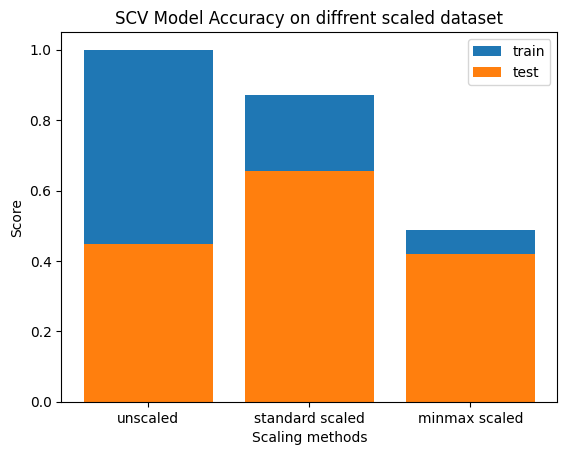

In [ ]:
# plot
plt.bar(names, train_scores)
plt.bar(names, test_scores)
plt.title("SCV Model Accuracy on diffrent scaled dataset")
plt.ylabel("Score")
plt.xlabel("Scaling methods")
plt.legend(["train", "test"], loc="best")
plt.show()
# symbol: plt
# hover info: (module) plt
#     import


As we can see:
- The model on standard scaled data performs the best, with training score of 83% and validation score of 64%.
- The model on unscaled data works in the middle, and it signals that the model is overfitting on training dataset, with training score of 100% and validation score of 45%.
- The model on min_max scaled data gets the lowest score, with training score of 44% and validation score of 37%.

### Cross validation

When adjusting models we are aiming to increase overall model performance on unseen data. Hyperparameter tuning can lead to much better performance on test sets. However, optimizing parameters to the test set can lead information leakage causing the model to preform worse on unseen data. To correct for this we can perform cross validation.

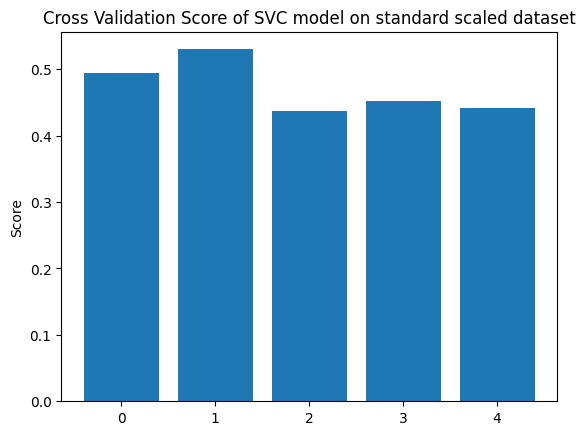

Mean= 0.4707905216606895 
Variance= 0.001264997670500353


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)
model = SVC(
    C=10,  #higher the value tighter the margin
    gamma='auto',
    kernel='rbf',
    random_state=69
)
scores = cross_val_score(model, features_scaled, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of SVC model on standard scaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

Summary:
- For SVC model, standard scaling is the best and the mean best test score is 42.6% after 5 cross validation.

### Hyperparameters Optimization

GridSearchCV is brute-force search over specified parameter values for an estimator. GridSearchCV has already implemented a “fit” and a “score” method. And it will run using the given params, e.g., models, scorling.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model = SVC(
    random_state=69
)
parameters = {
    'kernel':('linear', 'rbf','sigmoid'),
    'C':[0.1, 1, 10, 100],
    'gamma': ('scale', 'auto')
    }
# parameters = {
#     'kernel':['rbf'],
#     'C':[1, 10],
#     'gamma': ['auto']
#     }


grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, error_score="raise")
grid.fit(features_scaled, emotions)
# By default, parameter search uses the score function of the estimator to evaluate a parameter setting.

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.3s
[CV] END .................C=0.1, gamma=scale, k

GridSearchCV(error_score='raise', estimator=SVC(random_state=69),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'rbf', 'sigmoid')},
             verbose=2)

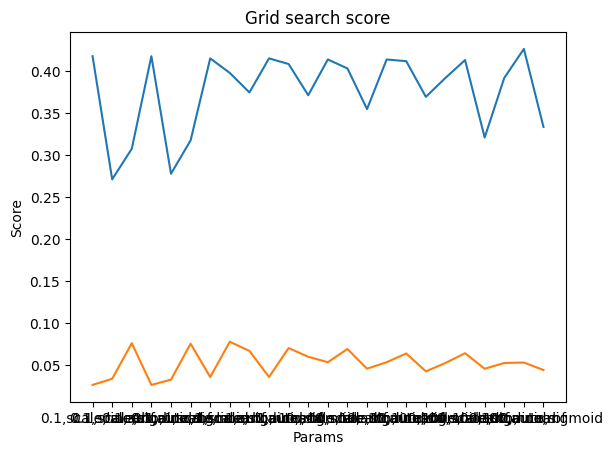

In [ ]:
def plot_grid_search(cv_results):
    params = cv_results["params"]
    x_names = []
    for dct in params:
        k = ",".join(str(v) for k,v in dct.items())
        # print(k)
        x_names.append(k)
    mean_test_scores = cv_results["mean_test_score"]
    std_test_scores = cv_results["std_test_score"]
    plt.plot(x_names, mean_test_scores, label="Mean")
    plt.plot(x_names, std_test_scores, label="Std")
    plt.title("Grid search score")
    plt.ylabel("Score")
    plt.xlabel("Params")
    plt.show()

plot_grid_search(grid.cv_results_)

Best params={'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}, score=0.42642186090515055


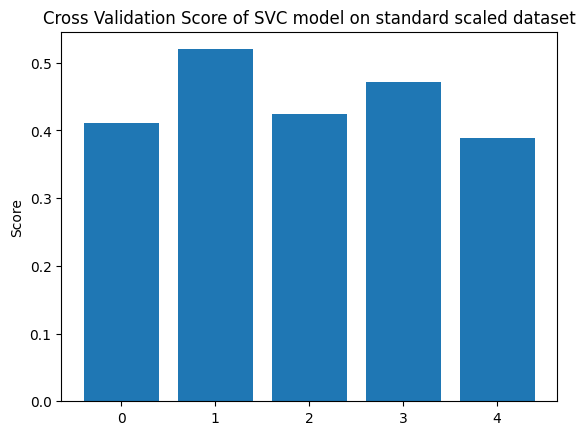

Mean= 0.4429539504081318 
Variance= 0.0022201793063042125


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

print(f"Best params={grid.best_params_}, score={grid.best_score_}")

k_folds = KFold(n_splits = 5)
model = grid.best_estimator_
scores = cross_val_score(model, features_scaled, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of SVC model on standard scaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

## KNN

### Baseline Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

####### Default kNN  ########
model = KNeighborsClassifier(
)

model.fit(X_train, y_train)

print(f'Default kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

##### (hastily) tuned kNN ######
model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute',
    n_jobs=4
)

model.fit(X_train, y_train)

print(f'kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default kNN Model's accuracy on training set is 70.98%
Default kNN Model's accuracy on test set is 53.31%

kNN Model's accuracy on training set is 100.00%
kNN Model's accuracy on test set is 57.95%


### Scores on different scaled dataset

In [ ]:
def get_score_on_scaled_data(model, X, y):
    X_train, X_test, y_train, y_test =train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=69
    )
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score


In [ ]:
X_list = []
X_list.append(features)
X_list.append(features_scaled)
X_list.append(features_minmax)
names = ["unscaled", "standard scaled", "minmax scaled"]
test_scores = []
train_scores = []

for X in X_list:
    model = KNeighborsClassifier(
        n_neighbors = 5,
        weights = 'distance',
        algorithm = 'brute',
        n_jobs=4
    )
    train_score, test_score = get_score_on_scaled_data(model, X, emotions)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(train_score, test_score)

1.0 0.5794701986754967
1.0 0.6059602649006622
1.0 0.6390728476821192


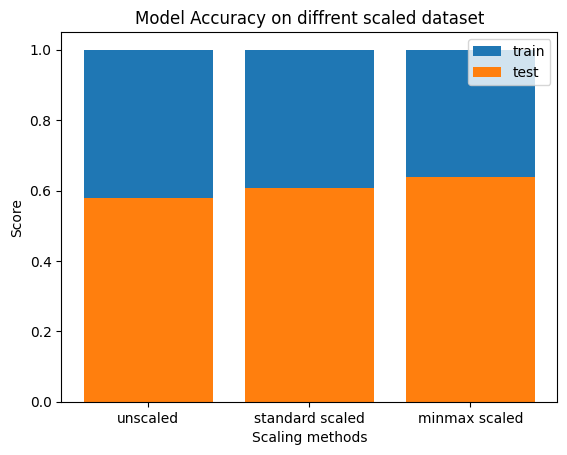

In [ ]:
# plot
plt.bar(names, train_scores)
plt.bar(names, test_scores)
plt.title("Model Accuracy on diffrent scaled dataset")
plt.ylabel("Score")
plt.xlabel("Scaling methods")
plt.legend(["train", "test"], loc="best")
plt.show()
# symbol: plt
# hover info: (module) plt
#     import


As we can see:
- The model on min_Max scaled data performs the best, with training score of 100% and validation score of 62%.
- The model on standard data works in the middle, with training score of 100% and validation score of 60%.
- The model on unscaled data gets the lowest score, with training score of 100% and validation score of 57%.

### Cross validation

When adjusting models we are aiming to increase overall model performance on unseen data. Hyperparameter tuning can lead to much better performance on test sets. However, optimizing parameters to the test set can lead information leakage causing the model to preform worse on unseen data. To correct for this we can perform cross validation.

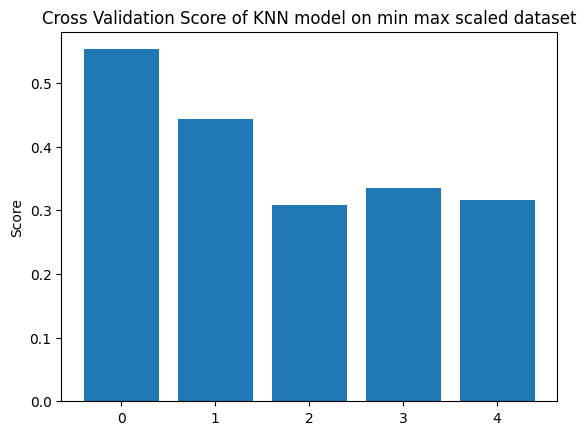

Mean= 0.3911597104574157 
Variance= 0.008934258348906404


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)
model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute',
    n_jobs=4
)
scores = cross_val_score(model, features_minmax, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of KNN model on min max scaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

Summary:
- For KNN model, min max scaling is the best and the mean best test score is 35.8% after 5 cross validation.

### Hyperparameters Optimization

GridSearchCV is brute-force search over specified parameter values for an estimator. GridSearchCV has already implemented a “fit” and a “score” method. And it will run using the given params, e.g., models, scorling.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier()
parameters = {
    'weights':('uniform', 'distance'),
    "n_neighbors": range(1,100,20),
    'algorithm':["auto", "kd_tree", "brute"],
    'leaf_size': range(1, 100, 30)
    }

grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, error_score="raise")
grid.fit(features_minmax, emotions)
# By default, parameter search uses the score function of the estimator to evaluate a parameter setting.

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.2s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=distance; total time=   0.2s
[CV] END algorithm=auto, leaf_size=1, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END algorithm=auto, leaf_size=1, n_ne

GridSearchCV(error_score='raise', estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'kd_tree', 'brute'],
                         'leaf_size': range(1, 100, 30),
                         'n_neighbors': range(1, 100, 20),
                         'weights': ('uniform', 'distance')},
             verbose=2)

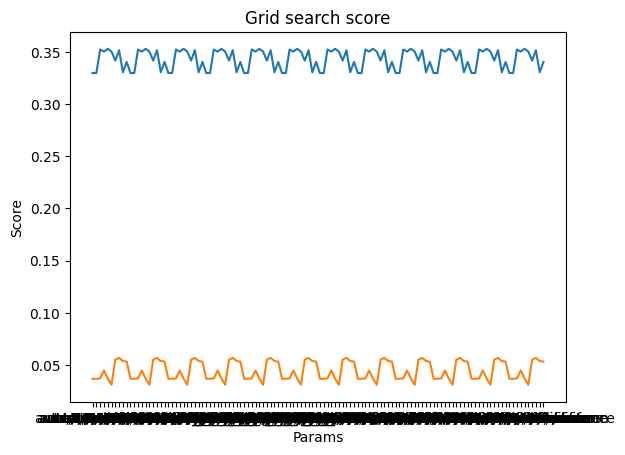

In [ ]:
def plot_grid_search(cv_results):
    params = cv_results["params"]
    x_names = []
    for dct in params:
        k = ",".join(str(v) for k,v in dct.items())
        # print(k)
        x_names.append(k)
    mean_test_scores = cv_results["mean_test_score"]
    std_test_scores = cv_results["std_test_score"]
    plt.plot(x_names, mean_test_scores, label="Mean")
    plt.plot(x_names, std_test_scores, label="Std")
    plt.title("Grid search score")
    plt.ylabel("Score")
    plt.xlabel("Params")
    plt.show()

plot_grid_search(grid.cv_results_)

Best params={'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 41, 'weights': 'uniform'}, score=0.35279531803480674


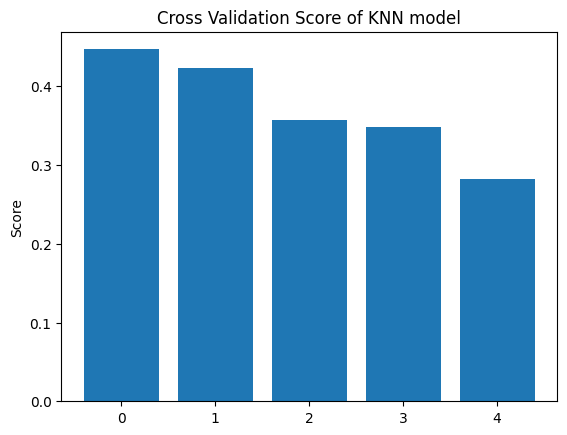

Mean= 0.3719412114144903 
Variance= 0.003417692997074299


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

print(f"Best params={grid.best_params_}, score={grid.best_score_}")

k_folds = KFold(n_splits = 5)
model = grid.best_estimator_
scores = cross_val_score(model, features_scaled, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of KNN model")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

## Random forest


### Baseline Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

####### Default Random Forest ########
model = RandomForestClassifier(
    random_state=69
)

model.fit(X_train, y_train)

print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')


########## Tuned Random Forest #######
model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=69
)

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default Random Forest Model's accuracy on training set is 100.00%
Default Random Forest Model's accuracy on test set is 60.26%

Random Forest Model's accuracy on training set is 100.00%
Random Forest Model's accuracy on test set is 62.58%


### Scores on different scaled dataset

In [ ]:
def get_score_on_scaled_data(model, X, y):
    X_train, X_test, y_train, y_test =train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=69
    )
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score


In [ ]:
X_list = []
X_list.append(features)
X_list.append(features_scaled)
X_list.append(features_minmax)
names = ["unscaled", "standard scaled", "minmax scaled"]
test_scores = []
train_scores = []

for X in X_list:
    model = RandomForestClassifier(
        n_estimators = 500,
        criterion ='entropy',
        warm_start = True,
        max_features = 'sqrt',
        oob_score = True, # more on this below
        random_state=69
    )
    train_score, test_score = get_score_on_scaled_data(model, X, emotions)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(train_score, test_score)

1.0 0.6258278145695364
1.0 0.6225165562913907
1.0 0.6192052980132451


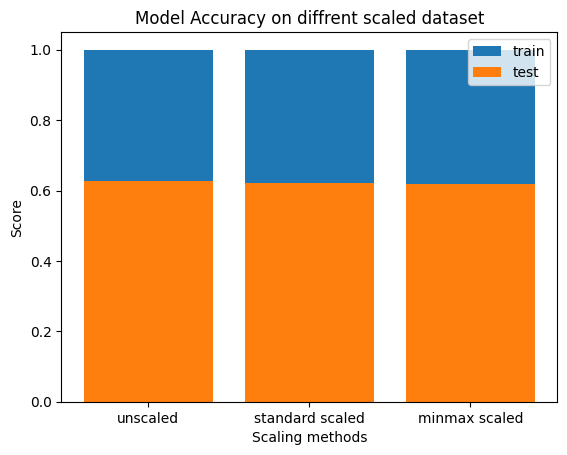

In [ ]:
# plot
plt.bar(names, train_scores)
plt.bar(names, test_scores)
plt.title("Model Accuracy on diffrent scaled dataset")
plt.ylabel("Score")
plt.xlabel("Scaling methods")
plt.legend(["train", "test"], loc="best")
plt.show()
# symbol: plt
# hover info: (module) plt
#     import


As we can see:
- All type of scaling data is the same, with training score of 100% and validation score of 63%.

### Cross validation

When adjusting models we are aiming to increase overall model performance on unseen data. Hyperparameter tuning can lead to much better performance on test sets. However, optimizing parameters to the test set can lead information leakage causing the model to preform worse on unseen data. To correct for this we can perform cross validation.

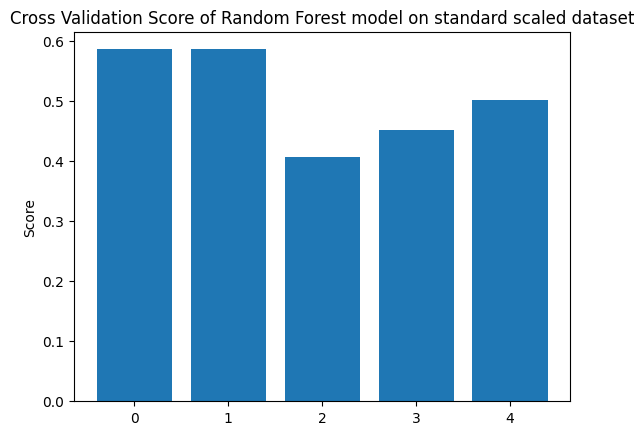

Mean= 0.506591714153704 
Variance= 0.005105229174851061


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)
model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=69
)
scores = cross_val_score(model, features_scaled, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of Random Forest model on standard scaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

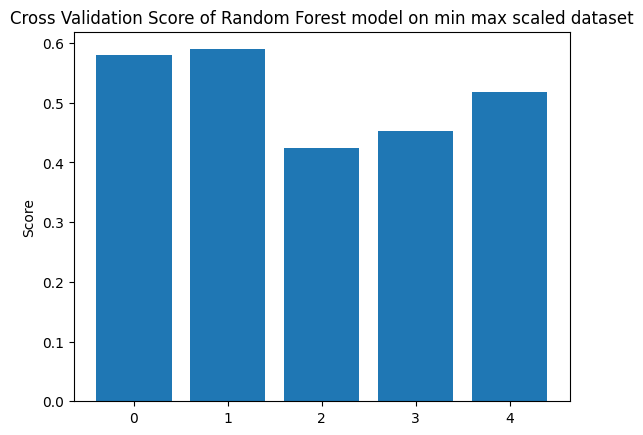

Mean= 0.5125629799124332 
Variance= 0.004394824185034754


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)
model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=69
)
scores = cross_val_score(model, features_minmax, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of Random Forest model on min max scaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

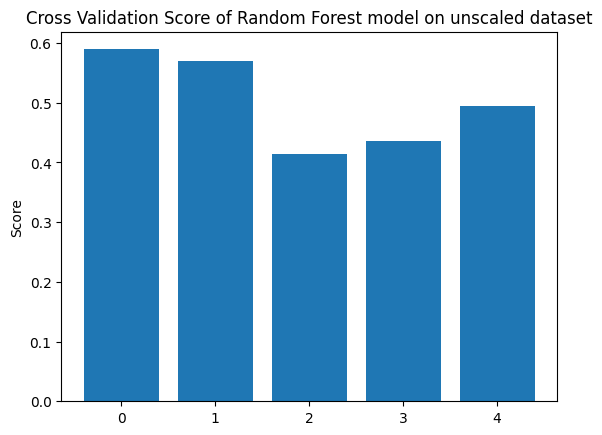

Mean= 0.500616048051748 
Variance= 0.004892050093251315


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)
model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=69
)
scores = cross_val_score(model, features, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of Random Forest model on unscaled dataset")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

Summary:
- For Random Forest model, min max scaling is the best and the mean best test score is 45.3% after 5 cross validation.

### Hyperparameters Optimization

GridSearchCV is brute-force search over specified parameter values for an estimator. GridSearchCV has already implemented a “fit” and a “score” method. And it will run using the given params, e.g., models, scorling.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(
    n_estimators = 500,
    warm_start = True,
    oob_score = True,
    random_state=69
)
parameters = {
    'criterion':('gini', 'entropy'),
    "max_depth": range(1,100,20),
    "min_samples_leaf": range(1,100,30)
    }


grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2, error_score="raise")
grid.fit(features_minmax, emotions)
# By default, parameter search uses the score function of the estimator to evaluate a parameter setting.

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ....criterion=gini, max_depth=1, min_samples_leaf=1; total time=   1.9s
[CV] END ....criterion=gini, max_depth=1, min_samples_leaf=1; total time=   2.5s
[CV] END ....criterion=gini, max_depth=1, min_samples_leaf=1; total time=   2.6s
[CV] END ....criterion=gini, max_depth=1, min_samples_leaf=1; total time=   1.9s
[CV] END ....criterion=gini, max_depth=1, min_samples_leaf=1; total time=   1.8s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=31; total time=   1.8s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=31; total time=   1.8s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=31; total time=   1.8s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=31; total time=   2.6s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=31; total time=   2.3s
[CV] END ...criterion=gini, max_depth=1, min_samples_leaf=61; total time=   1.8s
[CV] END ...criterion=gini, max_depth=1, min_sa

GridSearchCV(error_score='raise',
             estimator=RandomForestClassifier(n_estimators=500, oob_score=True,
                                              random_state=69,
                                              warm_start=True),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': range(1, 100, 20),
                         'min_samples_leaf': range(1, 100, 30)},
             verbose=2)

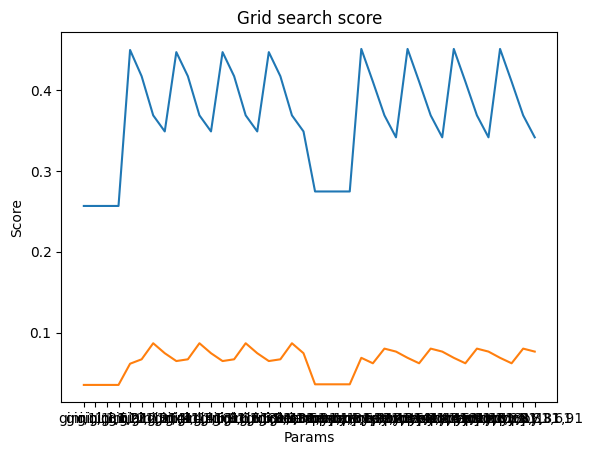

In [ ]:
def plot_grid_search(cv_results):
    params = cv_results["params"]
    x_names = []
    for dct in params:
        k = ",".join(str(v) for k,v in dct.items())
        # print(k)
        x_names.append(k)
    mean_test_scores = cv_results["mean_test_score"]
    std_test_scores = cv_results["std_test_score"]
    plt.plot(x_names, mean_test_scores, label="Mean")
    plt.plot(x_names, std_test_scores, label="Std")
    plt.title("Grid search score")
    plt.ylabel("Score")
    plt.xlabel("Params")
    plt.show()

plot_grid_search(grid.cv_results_)

Best params={'criterion': 'entropy', 'max_depth': 21, 'min_samples_leaf': 1}, score=0.4509339728498823


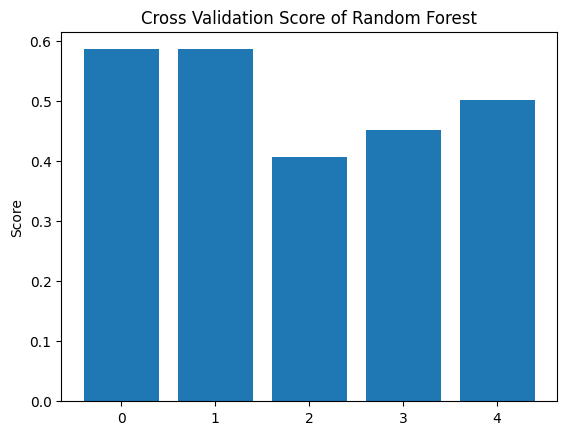

Mean= 0.506591714153704 
Variance= 0.005105229174851061


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

print(f"Best params={grid.best_params_}, score={grid.best_score_}")

k_folds = KFold(n_splits = 5)
model = grid.best_estimator_
scores = cross_val_score(model, features_scaled, emotions, cv = k_folds)

plt.bar(range(len(scores)), scores)
plt.title("Cross Validation Score of Random Forest")
plt.ylabel("Score")
plt.show()


print(f"Mean= {np.mean(scores)} \nVariance= {np.var(scores)}")

# Neural Networks

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

# Default 'off-the-shelf' MLP from sklearn
model = MLPClassifier(
    random_state = 69
)

#################### unscaled features #####################
X_train, X_test, y_train, y_test = train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=69
)

model.fit(X_train, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'Unscaled MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Unscaled MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')



Possible emotions predicted by model:['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
Unscaled MLP Model's accuracy on training set is 68.57%
Unscaled MLP Model's accuracy on test set is 53.64%


We try to get model performance on every scaled data set to choose the best suitable one with the technique of Cross_Validation.

i = 0, unscaled, train_score= 0.685737976782753, test_score= 0.5364238410596026
i = 1, standard scaled, train_score= 0.9029850746268657, test_score= 0.6688741721854304
i = 2, minmax scaled, train_score= 0.632669983416252, test_score= 0.5066225165562914


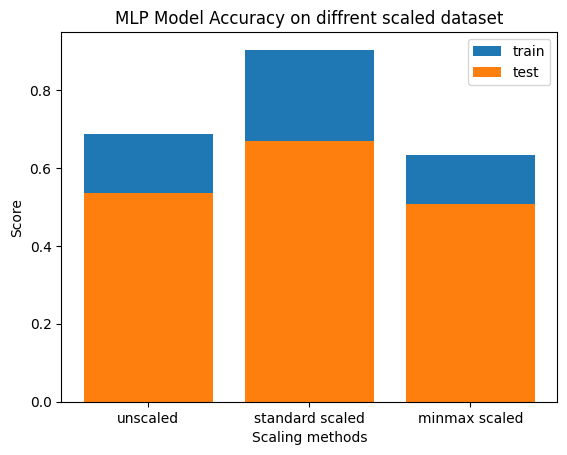

In [ ]:
def get_score_on_scaled_data(model, X, y):
    X_train, X_test, y_train, y_test =train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=69
    )
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score


X_list = []
X_list.append(features)
X_list.append(features_scaled)
X_list.append(features_minmax)
names = ["unscaled", "standard scaled", "minmax scaled"]
test_scores = []
train_scores = []

i = 0
for X in X_list:
    model = MLPClassifier(
        random_state = 69
    )
    train_score, test_score = get_score_on_scaled_data(model, X, emotions)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"i = {i}, {names[i]}, train_score= {train_score}, test_score= {test_score}")
    i+=1

# plot
plt.bar(names, train_scores)
plt.bar(names, test_scores)
plt.title("MLP Model Accuracy on diffrent scaled dataset")
plt.ylabel("Score")
plt.xlabel("Scaling methods")
plt.legend(["train", "test"], loc="best")
plt.show()
# symbol: plt
# hover info: (module) plt
#     import


## Choice of Hyperparameters

For the network architecture, I stick to the rule of thumb that few tasks would benefit from more than one hidden layer. I'll use a single hidden layer with the neuron numbers as a hyperparameters.

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend


# Now that we know standard scaling is best for our features, we'll use those for our training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

# Initialize the MLP Classifier and choose parameters we want to keep constant
model = MLPClassifier(
    # tune batch size later
    batch_size=256,
    # keep random state constant to accurately compare subsequent models
    random_state=69
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
parameter_space = {
    # A single hidden layer of size between 8 (output classes) and 180 (input features) neurons is most probable
    # It's a bad idea at guessing the number of hidden layers to have
    # ...but we'll give 2 and 3 hidden layers a shot to reaffirm our suspicions that 1 is best
    'hidden_layer_sizes': [(180,), (300,),(100,50,)],
    'activation': ['relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01],
    #'epsilon': [1e-08, 0.1],
    'learning_rate': ['adaptive', 'constant']
}

# Create a grid search object which will store the scores and hyperparameters of all candidate models
grid = GridSearchCV(
    model,
    parameter_space,
    cv=5,
    n_jobs=-1,
    verbose=10)
# Fit the models specified by the parameter grid
with parallel_backend('multiprocessing'):
    grid.fit(X_train, y_train)


# get the best hyperparameters from grid search object with its best_params_ attribute
print('Best parameters found:\n', grid.best_params_)

[CV 1/5; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd[CV 2/5; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.529 total time=   6.8s
[CV 3/5; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 2/5; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.481 total time=   7.0s
[CV 4/5; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 3/5; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.510 total time=   8.9s
[CV 5/5; 1/48] START activation=relu, alpha=0.001, hid

# MLP with Keras

In [ ]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

model = MLPClassifier(
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=256,
    hidden_layer_sizes=(300,),
    learning_rate='adaptive',
    max_iter=1000,
    random_state=69,
)

model.fit(X_train, y_train)

print(f'MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

MLP Model's accuracy on training set is 100.00%
MLP Model's accuracy on test set is 71.19%


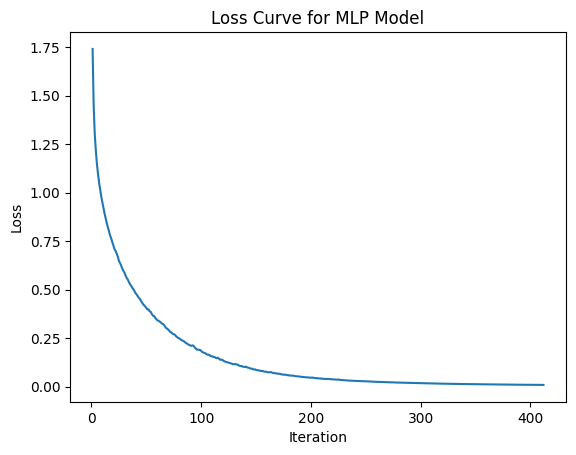

In [ ]:
plt.figure()
plt.plot([num for num in range(1,model.n_iter_ +1)], model.loss_curve_)
plt.title('Loss Curve for MLP Model')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

The confusion matrix

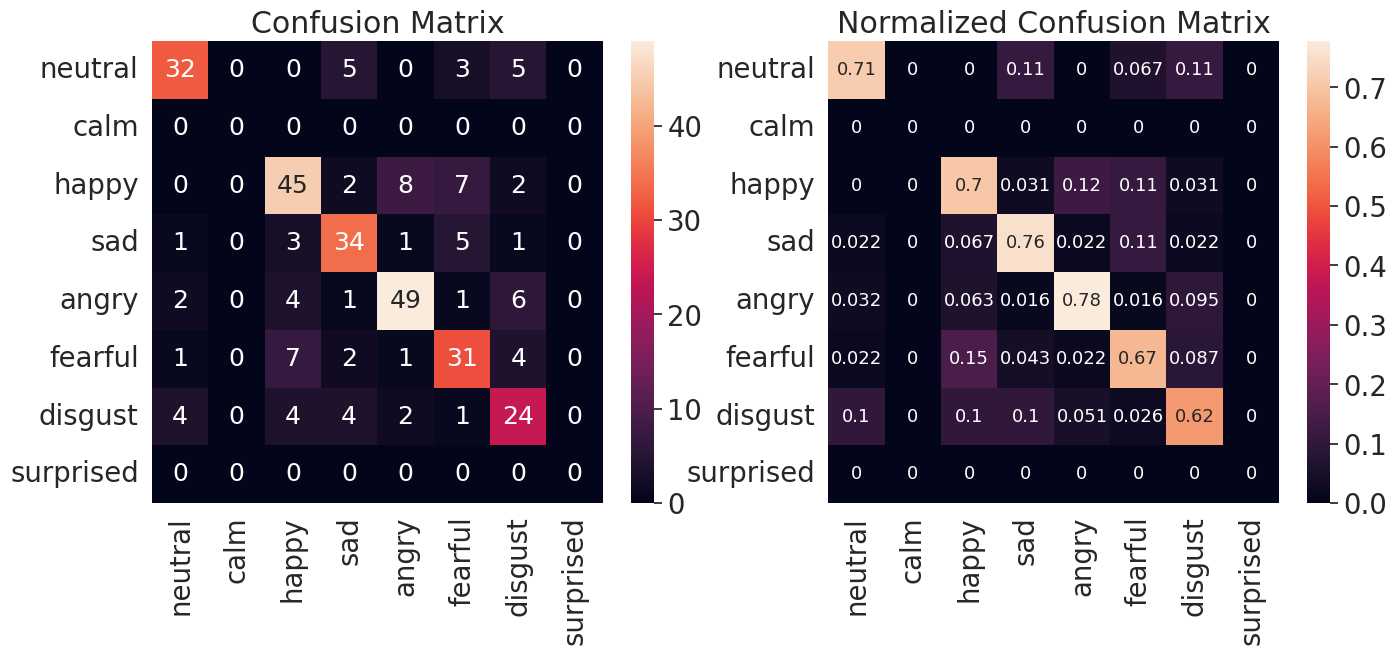

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn # I like seaborn's confusion matrix over sklearn's default

# get predictions on test set
test_emotion_predictions = model.predict(X_test)
test_emotion_groundtruth = y_test

# set labels for matrix axes from emotions
emotion_list =['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
emotion_name = [emotion for emotion in emotion_list]

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions, labels=emotion_list)
conf_matrix_norm = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions,normalize='true', labels=emotion_list)



# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_name, columns=emotion_name)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_name, columns=emotion_name)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(
    n_splits=10,
    random_state=69,
    shuffle=True
)

scores = []
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)
for train_indices, test_indices in kfold.split(X_train,y_train):



    train_x=X_train.iloc[train_indices]
    train_y=y_train.iloc[train_indices]

    test_x=X_train.iloc[test_indices]
    test_y=y_train.iloc[test_indices]
    # fit model to training fold
    model.fit(train_x, train_y)
    # score the model on validation fold
    scores.append(model.score(test_x, test_y))

print('KFold CV scores for MLP:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for MLP: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%')

KFold CV scores for MLP:
68.60%
67.77%
71.07%
75.21%
66.12%
65.29%
72.50%
72.50%
71.67%
70.00%
Mean score of KFold CV for MLP: 70.07% ± 2.96%


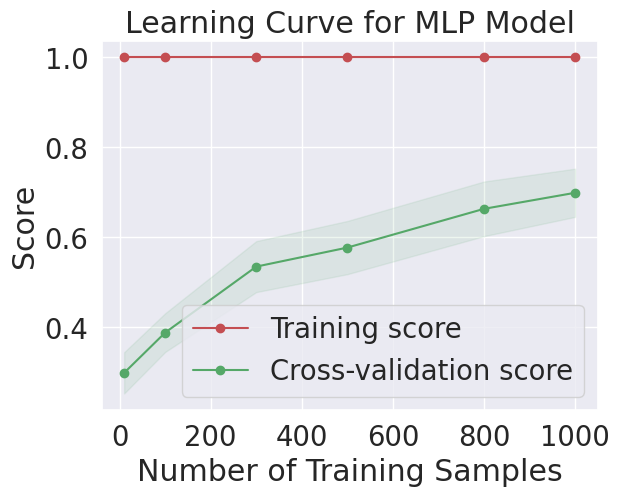

In [ ]:
from sklearn.model_selection import learning_curve

# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X=X_train,
    y=y_train,
    cv=10,
    shuffle=True,
    random_state=69,
    n_jobs=4,
    # We have (0.8*1440)/10 = 115/1150 training samples, 1035/1150 test samples
    train_sizes=[10,100,300,500,800, 1000] # bounded at 1035 for this dataset for 10-fold cv
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.title('Learning Curve for MLP Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()